# Imports

In [1]:
!pip install pytorch_msssim

In [2]:
import sys
import os
from PIL import Image
from glob import glob
import math
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
from timm import create_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns
from pytorch_msssim import ssim as ssim_torch  # Fast SSIM on GPU

# DataLoader

In [3]:
class NPYSuperResolutionDataset(Dataset):
    def __init__(self, samples_list, base_dir, transform):
        self.base_dir = base_dir
        self.file_names = samples_list
        self.transform = transform
 
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]

        # Load HR and LR images
        hr_img = np.load(os.path.join(self.base_dir, "HR", file_name))
        lr_img = np.load(os.path.join(self.base_dir, "LR", file_name))

        # Convert to PIL Image
        hr_img = Image.fromarray(np.uint8(hr_img.squeeze() * 255))
        lr_img = Image.fromarray(np.uint8(lr_img.squeeze() * 255))

        # Apply transformations
        if self.transform:
            lr_img, hr_img = self.transform(lr_img, hr_img)

        return lr_img, hr_img

class PairedTransform:
    def __init__(self, transform, save_dir="debug_images", debug=False):
        self.transform = transform
        self.save_dir = save_dir
        self.debug = debug
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    def __call__(self, img1, img2):
        seed = torch.randint(0, 10000, (1,)).item()  # Generate a random seed

        torch.manual_seed(seed)  # Set seed before applying to first image
        img1 = self.transform(img1)

        torch.manual_seed(seed)  # Reset seed before applying to second image
        img2 = self.transform(img2)

        if self.debug:
            # Save the transformed images for debugging
            img1_save_path = os.path.join(self.save_dir, f"{seed}_img1_debug.png")
            img2_save_path = os.path.join(self.save_dir, f"{seed}_img2_debug.png")

            img1_pil = transforms.ToPILImage()(img1)  # Convert tensor back to PIL
            img2_pil = transforms.ToPILImage()(img2)

            img1_pil.save(img1_save_path)
            img2_pil.save(img2_save_path)


        return img1, img2

In [4]:
train_transforms = transforms.Compose([
    # transforms.CenterCrop(100),
    transforms.Resize(150, Image.LANCZOS),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
        transforms.Resize(150, Image.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
paired_transform = PairedTransform(transform=train_transforms)
paired_transform_val = PairedTransform(transform=val_transforms)

dataset_root = "/kaggle/input/deeplense/SpecificTest_06_B/Dataset"

file_names = sorted([f for f in os.listdir(os.path.join(dataset_root, "HR")) if f.startswith("sample") and f.endswith(".npy")])
train_files, val_files = train_test_split(file_names, test_size=0.1, random_state=42)

# Train MAE only on no_sub_train_files
batch_size=256
train_dataset = NPYSuperResolutionDataset(train_files, dataset_root, paired_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Validation set for MAE (later used in classification also)
val_dataset = NPYSuperResolutionDataset(val_files, dataset_root, paired_transform_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

## Model Architecture

In [6]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [7]:
class EncoderViT(nn.Module):
    def __init__(self, base="tiny", p=0.25):
        super(EncoderViT, self).__init__()

        modelss = create_model(f"vit_{base}_patch16_224", pretrained=True)
        modelss.patch_embed = nn.Identity()
        modelss.head = nn.Identity() # now output shape is embed_dim (tiny: 192, base: 768)
        self.set_dropout(modelss, p)

        # self.model.pos_embed = nn.Identity()  # Bypass position encoding in timm
        # Override `_pos_embed()` so ViT doesn’t add its own position embedding
        # def forward_pos_embed(x):
        #     return x 
        # self.model._pos_embed = forward_pos_embed

        self.encoder_blocks = modelss.blocks
        self.norm = modelss.norm

    def set_dropout(self, model, p):
        """Recursively set dropout probability in a model."""
        for name, module in model.named_modules():
            if isinstance(module, nn.Dropout):
                module.p = p

    def forward(self, x):
        for block in self.encoder_blocks:
            x = block(x)

        x = self.norm(x)

        return x

class MAEDecoder(nn.Module):
    def __init__(self, embed_dim=192, output_patch=256, num_layers=2, num_heads=6):
        super().__init__()

        # Transformer decoder layers
        self.decoder_blocks = nn.Sequential(*[
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim * 4)
            for _ in range(num_layers)
        ])

        self.final_layer = nn.Linear(embed_dim, output_patch)  # Output patch embeddings

    def forward(self, x):
        x = self.decoder_blocks(x)  # Apply transformer decoder layers
        return self.final_layer(x)  # Shape: [batch_size, num_patches, embed_dim]

# Define the Encoder (ViT model)
class SuperResolutionViT(nn.Module):
    def __init__(self, base="tiny", input_dim=256, embed_dim=192, num_patches=196, p=0.25):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedInput = nn.Linear(input_dim, self.embed_dim)
        self.encoder = EncoderViT(base=base, p=p)
        self.decoder = MAEDecoder(output_patch=input_dim, embed_dim=embed_dim)
        checkpoint = torch.load("/kaggle/input/specific_task_06/pytorch/default/2/encoder_embedInput.pth", weights_only=True)

        self.embedInput.load_state_dict(checkpoint["embedInput"])
        self.encoder.load_state_dict(checkpoint["encoder"])

        self.num_patches = num_patches

        # Compute and store full position encoding ONCE
        self.register_buffer("full_position_encoding", self.sinusoidal_position_encoding(num_patches, self.embed_dim).unsqueeze(0))
        # self.full_position_encoding = nn.Parameter(torch.randn(1, num_patches, self.embed_dim))  # Learnable

    def forward(self, x):
        batch_size = x.shape[0]
        full_pos_encoding = self.full_position_encoding.expand(batch_size, -1, -1)

        x = self.embedInput(x) + full_pos_encoding # (bs, visible_patches, embed_dim)

        # Encode only visible patches
        encoded = self.encoder(x)

        # Decode
        full_pos_encoding = self.full_position_encoding.expand(batch_size, -1, -1)  # Shape: [batch_size, 196, embed_dim]
        full_tokens = encoded + full_pos_encoding

        reconstructed = self.decoder(full_tokens)
        return reconstructed

    def sinusoidal_position_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches).unsqueeze(1)  # Shape: (num_patches, 1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))

        pe = torch.zeros(num_patches, embed_dim)
        pe[:, 1::2] = torch.sin(position * div_term)
        pe[:, 0::2] = torch.cos(position * div_term)

        return pe  # Shape: (num_patches, embed_dim)

## Training

In [8]:
torch.cuda.empty_cache()

In [9]:
def image_to_patches(img_tensor, patch_size=16):
    _, C, H, W = img_tensor.shape
    num_patches = (H // patch_size) * (W // patch_size)

    # Split into patches
    img_patches = img_tensor.unfold(2, patch_size, patch_size) # [1, 1, 224, 224] -> [1, 1, 14, 224, 16]
    img_patches = img_patches.unfold(3, patch_size, patch_size)  # [1, 1, 14, 224, 16] -> [1, 1, 14, 14, 16, 16]
    img_patches = img_patches.contiguous().view(-1, num_patches, patch_size * patch_size)  # Flatten patches [1, 1, 14, 14, 16, 16] -> [1, 196, 256]

    return img_patches

In [10]:
patch_size = 10
input_dim = patch_size**2
num_patches = int(150/patch_size)**2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SuperResolutionViT(input_dim=input_dim, num_patches=num_patches).to(device)
model = nn.DataParallel(model)

# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=2e-6) #  , weight_decay=2e-4 , weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)
criterion = nn.MSELoss() # nn.MSELoss

# Track metrics
train_losses, val_losses = [], []
train_losses, val_losses = [], []
val_psnrs, val_ssims = [], []
train_psnrs, train_ssims = [], []

# Training Loop
num_epochs = 200
best_val_loss = 10000000.0

best_psnr = 0.0  # Track best PSNR
best_ssim = 0.0  # Track best SSIM

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0

    for lr_images, hr_images in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        lr_images, hr_images = lr_images.to(device), hr_images.to(device)

        optimizer.zero_grad()
        lr_images = image_to_patches(lr_images, 10)
        output = model(lr_images)

        loss = criterion(output.view(lr_images.shape[0], -1), hr_images.view(lr_images.shape[0], -1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        output = output.contiguous().view(-1, 1, 150, 150)

        # Compute MSE on GPU
        mse = torch.mean(F.mse_loss(output, hr_images, reduction='none'), dim=[1, 2, 3])
        batch_psnr = 10 * torch.log10(2.0 / mse)  # PSNR formula

        # Compute SSIM on GPU
        batch_ssim = ssim_torch(output, hr_images, data_range=2.0, size_average=False)  # (B,)

        total_psnr += batch_psnr.mean().item()
        total_ssim += batch_ssim.mean().item()

    train_loss = running_loss / len(train_loader)
    avg_psnr_train = total_psnr / len(train_loader)
    avg_ssim_train = total_ssim / len(train_loader)

    train_psnrs.append(avg_psnr_train)
    train_ssims.append(avg_ssim_train)
    train_losses.append(train_loss)

    # Validation Step
    model.eval()
    val_loss = 0.0
    total_psnr, total_ssim = 0.0, 0.0

    with torch.no_grad():
        for lr_images, hr_images in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            lr_images, hr_images = lr_images.to(device), hr_images.to(device)

            lr_images = image_to_patches(lr_images, 10)
            output = model(lr_images)

            val_loss += criterion(output.view(lr_images.shape[0], -1), hr_images.view(lr_images.shape[0], -1)).item()
    
            output = output.contiguous().view(-1, 1, 150, 150)
            # Compute MSE on GPU
            mse = torch.mean(F.mse_loss(output, hr_images, reduction='none'), dim=[1, 2, 3])
            batch_psnr = 10 * torch.log10(2.0 / mse)  # PSNR formula

            # Compute SSIM on GPU
            batch_ssim = ssim_torch(output, hr_images, data_range=2.0, size_average=False)  # (B,)

            total_psnr += batch_psnr.mean().item()
            total_ssim += batch_ssim.mean().item()

    val_loss /= len(val_loader)
    avg_psnr = total_psnr / len(val_loader)
    avg_ssim = total_ssim / len(val_loader)

    val_losses.append(val_loss)
    val_psnrs.append(avg_psnr)
    val_ssims.append(avg_ssim)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train_PSNR: {avg_psnr_train:.2f} | Val_PSNR: {avg_psnr:.2f} | Train_SSIM: {avg_ssim_train:.4f} | Val_SSIM: {avg_ssim:.4f}")

    # Save Best Model based on PSNR
    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        torch.save(model.state_dict(), "best_vit_PSNR_model.pth")
        print("Model Saved (Best PSNR)")

    # Save Best Model based on SSIM
    if avg_ssim > best_ssim:
        best_ssim = avg_ssim
        torch.save(model.state_dict(), "best_vit_SSIM_model.pth")
        print("Model Saved (Best SSIM)")

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/200:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
Epoch 1/200: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


Epoch [1/200] | Train Loss: 0.2618 | Val Loss: 0.0580 | Train_PSNR: 10.44 | Val_PSNR: 15.51 | Train_SSIM: 0.0726 | Val_SSIM: 0.4528
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 2/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [2/200] | Train Loss: 0.0685 | Val Loss: 0.0541 | Train_PSNR: 14.75 | Val_PSNR: 15.86 | Train_SSIM: 0.1941 | Val_SSIM: 0.6776
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 3/200: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Epoch [3/200] | Train Loss: 0.0625 | Val Loss: 0.0475 | Train_PSNR: 15.16 | Val_PSNR: 16.38 | Train_SSIM: 0.2153 | Val_SSIM: 0.4584
Model Saved (Best PSNR)


Epoch 4/200: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Epoch [4/200] | Train Loss: 0.0553 | Val Loss: 0.0430 | Train_PSNR: 15.68 | Val_PSNR: 16.82 | Train_SSIM: 0.2281 | Val_SSIM: 0.6276
Model Saved (Best PSNR)


Epoch 5/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [5/200] | Train Loss: 0.0518 | Val Loss: 0.0420 | Train_PSNR: 15.97 | Val_PSNR: 16.92 | Train_SSIM: 0.2612 | Val_SSIM: 0.7230
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 6/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [6/200] | Train Loss: 0.0501 | Val Loss: 0.0415 | Train_PSNR: 16.12 | Val_PSNR: 16.98 | Train_SSIM: 0.2828 | Val_SSIM: 0.7344
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 7/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [7/200] | Train Loss: 0.0489 | Val Loss: 0.0405 | Train_PSNR: 16.23 | Val_PSNR: 17.08 | Train_SSIM: 0.2999 | Val_SSIM: 0.7283
Model Saved (Best PSNR)


Epoch 8/200: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch [8/200] | Train Loss: 0.0472 | Val Loss: 0.0392 | Train_PSNR: 16.38 | Val_PSNR: 17.23 | Train_SSIM: 0.3155 | Val_SSIM: 0.7265
Model Saved (Best PSNR)


Epoch 9/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [9/200] | Train Loss: 0.0456 | Val Loss: 0.0381 | Train_PSNR: 16.53 | Val_PSNR: 17.36 | Train_SSIM: 0.3321 | Val_SSIM: 0.7247
Model Saved (Best PSNR)


Epoch 10/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [10/200] | Train Loss: 0.0444 | Val Loss: 0.0374 | Train_PSNR: 16.65 | Val_PSNR: 17.43 | Train_SSIM: 0.3499 | Val_SSIM: 0.7310
Model Saved (Best PSNR)


Epoch 11/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [11/200] | Train Loss: 0.0435 | Val Loss: 0.0371 | Train_PSNR: 16.74 | Val_PSNR: 17.47 | Train_SSIM: 0.3684 | Val_SSIM: 0.7361
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 12/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [12/200] | Train Loss: 0.0426 | Val Loss: 0.0368 | Train_PSNR: 16.83 | Val_PSNR: 17.50 | Train_SSIM: 0.3864 | Val_SSIM: 0.7395
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 13/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [13/200] | Train Loss: 0.0421 | Val Loss: 0.0365 | Train_PSNR: 16.87 | Val_PSNR: 17.53 | Train_SSIM: 0.4032 | Val_SSIM: 0.7421
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 14/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [14/200] | Train Loss: 0.0416 | Val Loss: 0.0361 | Train_PSNR: 16.93 | Val_PSNR: 17.58 | Train_SSIM: 0.4191 | Val_SSIM: 0.7450
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 15/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [15/200] | Train Loss: 0.0408 | Val Loss: 0.0359 | Train_PSNR: 17.01 | Val_PSNR: 17.61 | Train_SSIM: 0.4334 | Val_SSIM: 0.7420
Model Saved (Best PSNR)


Epoch 16/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [16/200] | Train Loss: 0.0406 | Val Loss: 0.0354 | Train_PSNR: 17.04 | Val_PSNR: 17.66 | Train_SSIM: 0.4466 | Val_SSIM: 0.7378
Model Saved (Best PSNR)


Epoch 17/200: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Epoch [17/200] | Train Loss: 0.0399 | Val Loss: 0.0349 | Train_PSNR: 17.12 | Val_PSNR: 17.72 | Train_SSIM: 0.4577 | Val_SSIM: 0.7307
Model Saved (Best PSNR)


Epoch 18/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [18/200] | Train Loss: 0.0391 | Val Loss: 0.0341 | Train_PSNR: 17.20 | Val_PSNR: 17.83 | Train_SSIM: 0.4653 | Val_SSIM: 0.7076
Model Saved (Best PSNR)


Epoch 19/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [19/200] | Train Loss: 0.0381 | Val Loss: 0.0346 | Train_PSNR: 17.30 | Val_PSNR: 17.76 | Train_SSIM: 0.4657 | Val_SSIM: 0.6535


Epoch 20/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [20/200] | Train Loss: 0.0366 | Val Loss: 0.0331 | Train_PSNR: 17.48 | Val_PSNR: 17.94 | Train_SSIM: 0.4600 | Val_SSIM: 0.6189
Model Saved (Best PSNR)


Epoch 21/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [21/200] | Train Loss: 0.0344 | Val Loss: 0.0271 | Train_PSNR: 17.75 | Val_PSNR: 18.79 | Train_SSIM: 0.4547 | Val_SSIM: 0.6439
Model Saved (Best PSNR)


Epoch 22/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [22/200] | Train Loss: 0.0315 | Val Loss: 0.0243 | Train_PSNR: 18.13 | Val_PSNR: 19.30 | Train_SSIM: 0.4578 | Val_SSIM: 0.6607
Model Saved (Best PSNR)


Epoch 23/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [23/200] | Train Loss: 0.0287 | Val Loss: 0.0240 | Train_PSNR: 18.53 | Val_PSNR: 19.38 | Train_SSIM: 0.4631 | Val_SSIM: 0.6605
Model Saved (Best PSNR)


Epoch 24/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [24/200] | Train Loss: 0.0266 | Val Loss: 0.0269 | Train_PSNR: 18.85 | Val_PSNR: 18.91 | Train_SSIM: 0.4757 | Val_SSIM: 0.6326


Epoch 25/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [25/200] | Train Loss: 0.0256 | Val Loss: 0.0222 | Train_PSNR: 19.03 | Val_PSNR: 19.79 | Train_SSIM: 0.4871 | Val_SSIM: 0.6829
Model Saved (Best PSNR)


Epoch 26/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [26/200] | Train Loss: 0.0243 | Val Loss: 0.0228 | Train_PSNR: 19.26 | Val_PSNR: 19.67 | Train_SSIM: 0.4990 | Val_SSIM: 0.6845


Epoch 27/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [27/200] | Train Loss: 0.0233 | Val Loss: 0.0220 | Train_PSNR: 19.46 | Val_PSNR: 19.83 | Train_SSIM: 0.5117 | Val_SSIM: 0.6965
Model Saved (Best PSNR)


Epoch 28/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [28/200] | Train Loss: 0.0226 | Val Loss: 0.0226 | Train_PSNR: 19.59 | Val_PSNR: 19.73 | Train_SSIM: 0.5214 | Val_SSIM: 0.6949


Epoch 29/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [29/200] | Train Loss: 0.0219 | Val Loss: 0.0202 | Train_PSNR: 19.73 | Val_PSNR: 20.23 | Train_SSIM: 0.5302 | Val_SSIM: 0.7199
Model Saved (Best PSNR)


Epoch 30/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [30/200] | Train Loss: 0.0215 | Val Loss: 0.0223 | Train_PSNR: 19.82 | Val_PSNR: 19.78 | Train_SSIM: 0.5384 | Val_SSIM: 0.7110


Epoch 31/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [31/200] | Train Loss: 0.0210 | Val Loss: 0.0214 | Train_PSNR: 19.92 | Val_PSNR: 19.94 | Train_SSIM: 0.5469 | Val_SSIM: 0.7155


Epoch 32/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [32/200] | Train Loss: 0.0204 | Val Loss: 0.0198 | Train_PSNR: 20.05 | Val_PSNR: 20.30 | Train_SSIM: 0.5549 | Val_SSIM: 0.7297
Model Saved (Best PSNR)


Epoch 33/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [33/200] | Train Loss: 0.0202 | Val Loss: 0.0207 | Train_PSNR: 20.10 | Val_PSNR: 20.09 | Train_SSIM: 0.5609 | Val_SSIM: 0.7285


Epoch 34/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [34/200] | Train Loss: 0.0198 | Val Loss: 0.0179 | Train_PSNR: 20.17 | Val_PSNR: 20.73 | Train_SSIM: 0.5662 | Val_SSIM: 0.7454
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 35/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [35/200] | Train Loss: 0.0193 | Val Loss: 0.0190 | Train_PSNR: 20.29 | Val_PSNR: 20.43 | Train_SSIM: 0.5726 | Val_SSIM: 0.7421


Epoch 36/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [36/200] | Train Loss: 0.0189 | Val Loss: 0.0195 | Train_PSNR: 20.38 | Val_PSNR: 20.32 | Train_SSIM: 0.5775 | Val_SSIM: 0.7355


Epoch 37/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [37/200] | Train Loss: 0.0186 | Val Loss: 0.0201 | Train_PSNR: 20.46 | Val_PSNR: 20.16 | Train_SSIM: 0.5822 | Val_SSIM: 0.7316


Epoch 38/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [38/200] | Train Loss: 0.0182 | Val Loss: 0.0209 | Train_PSNR: 20.57 | Val_PSNR: 20.00 | Train_SSIM: 0.5853 | Val_SSIM: 0.7308


Epoch 39/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [39/200] | Train Loss: 0.0178 | Val Loss: 0.0178 | Train_PSNR: 20.65 | Val_PSNR: 20.70 | Train_SSIM: 0.5883 | Val_SSIM: 0.7513
Model Saved (Best SSIM)


Epoch 40/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [40/200] | Train Loss: 0.0173 | Val Loss: 0.0173 | Train_PSNR: 20.79 | Val_PSNR: 20.82 | Train_SSIM: 0.5946 | Val_SSIM: 0.7528
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 41/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [41/200] | Train Loss: 0.0170 | Val Loss: 0.0154 | Train_PSNR: 20.88 | Val_PSNR: 21.36 | Train_SSIM: 0.5987 | Val_SSIM: 0.7655
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 42/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [42/200] | Train Loss: 0.0165 | Val Loss: 0.0149 | Train_PSNR: 21.00 | Val_PSNR: 21.47 | Train_SSIM: 0.6049 | Val_SSIM: 0.7671
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 43/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [43/200] | Train Loss: 0.0162 | Val Loss: 0.0152 | Train_PSNR: 21.07 | Val_PSNR: 21.40 | Train_SSIM: 0.6084 | Val_SSIM: 0.7691
Model Saved (Best SSIM)


Epoch 44/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [44/200] | Train Loss: 0.0158 | Val Loss: 0.0146 | Train_PSNR: 21.20 | Val_PSNR: 21.59 | Train_SSIM: 0.6138 | Val_SSIM: 0.7729
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 45/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [45/200] | Train Loss: 0.0156 | Val Loss: 0.0151 | Train_PSNR: 21.26 | Val_PSNR: 21.44 | Train_SSIM: 0.6177 | Val_SSIM: 0.7725


Epoch 46/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [46/200] | Train Loss: 0.0153 | Val Loss: 0.0142 | Train_PSNR: 21.33 | Val_PSNR: 21.72 | Train_SSIM: 0.6196 | Val_SSIM: 0.7806
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 47/200: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch [47/200] | Train Loss: 0.0149 | Val Loss: 0.0143 | Train_PSNR: 21.47 | Val_PSNR: 21.68 | Train_SSIM: 0.6255 | Val_SSIM: 0.7817
Model Saved (Best SSIM)


Epoch 48/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [48/200] | Train Loss: 0.0147 | Val Loss: 0.0142 | Train_PSNR: 21.52 | Val_PSNR: 21.69 | Train_SSIM: 0.6303 | Val_SSIM: 0.7825
Model Saved (Best SSIM)


Epoch 49/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [49/200] | Train Loss: 0.0144 | Val Loss: 0.0133 | Train_PSNR: 21.62 | Val_PSNR: 21.98 | Train_SSIM: 0.6340 | Val_SSIM: 0.7878
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 50/200: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Epoch [50/200] | Train Loss: 0.0145 | Val Loss: 0.0137 | Train_PSNR: 21.60 | Val_PSNR: 21.86 | Train_SSIM: 0.6352 | Val_SSIM: 0.7842


Epoch 51/200: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


Epoch [51/200] | Train Loss: 0.0137 | Val Loss: 0.0131 | Train_PSNR: 21.82 | Val_PSNR: 22.06 | Train_SSIM: 0.6400 | Val_SSIM: 0.7885
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 52/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [52/200] | Train Loss: 0.0135 | Val Loss: 0.0131 | Train_PSNR: 21.91 | Val_PSNR: 22.05 | Train_SSIM: 0.6427 | Val_SSIM: 0.7925
Model Saved (Best SSIM)


Epoch 53/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [53/200] | Train Loss: 0.0132 | Val Loss: 0.0137 | Train_PSNR: 22.00 | Val_PSNR: 21.84 | Train_SSIM: 0.6443 | Val_SSIM: 0.7875


Epoch 54/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [54/200] | Train Loss: 0.0128 | Val Loss: 0.0124 | Train_PSNR: 22.11 | Val_PSNR: 22.28 | Train_SSIM: 0.6482 | Val_SSIM: 0.7972
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 55/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [55/200] | Train Loss: 0.0125 | Val Loss: 0.0121 | Train_PSNR: 22.21 | Val_PSNR: 22.40 | Train_SSIM: 0.6497 | Val_SSIM: 0.7912
Model Saved (Best PSNR)


Epoch 56/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [56/200] | Train Loss: 0.0120 | Val Loss: 0.0119 | Train_PSNR: 22.38 | Val_PSNR: 22.47 | Train_SSIM: 0.6548 | Val_SSIM: 0.8047
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 57/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [57/200] | Train Loss: 0.0117 | Val Loss: 0.0122 | Train_PSNR: 22.50 | Val_PSNR: 22.34 | Train_SSIM: 0.6568 | Val_SSIM: 0.7939


Epoch 58/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [58/200] | Train Loss: 0.0114 | Val Loss: 0.0122 | Train_PSNR: 22.60 | Val_PSNR: 22.32 | Train_SSIM: 0.6591 | Val_SSIM: 0.7925


Epoch 59/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [59/200] | Train Loss: 0.0110 | Val Loss: 0.0111 | Train_PSNR: 22.78 | Val_PSNR: 22.73 | Train_SSIM: 0.6627 | Val_SSIM: 0.8074
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 60/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [60/200] | Train Loss: 0.0106 | Val Loss: 0.0107 | Train_PSNR: 22.92 | Val_PSNR: 22.90 | Train_SSIM: 0.6674 | Val_SSIM: 0.8090
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 61/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [61/200] | Train Loss: 0.0102 | Val Loss: 0.0107 | Train_PSNR: 23.07 | Val_PSNR: 22.86 | Train_SSIM: 0.6705 | Val_SSIM: 0.8036


Epoch 62/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [62/200] | Train Loss: 0.0100 | Val Loss: 0.0109 | Train_PSNR: 23.18 | Val_PSNR: 22.79 | Train_SSIM: 0.6728 | Val_SSIM: 0.8078


Epoch 63/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [63/200] | Train Loss: 0.0097 | Val Loss: 0.0101 | Train_PSNR: 23.32 | Val_PSNR: 23.12 | Train_SSIM: 0.6764 | Val_SSIM: 0.8043
Model Saved (Best PSNR)


Epoch 64/200: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch [64/200] | Train Loss: 0.0094 | Val Loss: 0.0091 | Train_PSNR: 23.46 | Val_PSNR: 23.57 | Train_SSIM: 0.6803 | Val_SSIM: 0.8222
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 65/200: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch [65/200] | Train Loss: 0.0090 | Val Loss: 0.0094 | Train_PSNR: 23.62 | Val_PSNR: 23.44 | Train_SSIM: 0.6846 | Val_SSIM: 0.8188


Epoch 66/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [66/200] | Train Loss: 0.0088 | Val Loss: 0.0095 | Train_PSNR: 23.74 | Val_PSNR: 23.38 | Train_SSIM: 0.6876 | Val_SSIM: 0.8167


Epoch 67/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [67/200] | Train Loss: 0.0085 | Val Loss: 0.0082 | Train_PSNR: 23.86 | Val_PSNR: 24.05 | Train_SSIM: 0.6916 | Val_SSIM: 0.8304
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 68/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [68/200] | Train Loss: 0.0083 | Val Loss: 0.0086 | Train_PSNR: 23.97 | Val_PSNR: 23.83 | Train_SSIM: 0.6946 | Val_SSIM: 0.8276


Epoch 69/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [69/200] | Train Loss: 0.0081 | Val Loss: 0.0078 | Train_PSNR: 24.11 | Val_PSNR: 24.26 | Train_SSIM: 0.6986 | Val_SSIM: 0.8350
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 70/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [70/200] | Train Loss: 0.0079 | Val Loss: 0.0081 | Train_PSNR: 24.18 | Val_PSNR: 24.09 | Train_SSIM: 0.7015 | Val_SSIM: 0.8282


Epoch 71/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [71/200] | Train Loss: 0.0077 | Val Loss: 0.0071 | Train_PSNR: 24.29 | Val_PSNR: 24.68 | Train_SSIM: 0.7048 | Val_SSIM: 0.8349
Model Saved (Best PSNR)


Epoch 72/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [72/200] | Train Loss: 0.0075 | Val Loss: 0.0069 | Train_PSNR: 24.41 | Val_PSNR: 24.78 | Train_SSIM: 0.7082 | Val_SSIM: 0.8477
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 73/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [73/200] | Train Loss: 0.0074 | Val Loss: 0.0067 | Train_PSNR: 24.51 | Val_PSNR: 24.92 | Train_SSIM: 0.7114 | Val_SSIM: 0.8464
Model Saved (Best PSNR)


Epoch 74/200: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Epoch [74/200] | Train Loss: 0.0072 | Val Loss: 0.0071 | Train_PSNR: 24.60 | Val_PSNR: 24.69 | Train_SSIM: 0.7141 | Val_SSIM: 0.8399


Epoch 75/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [75/200] | Train Loss: 0.0070 | Val Loss: 0.0068 | Train_PSNR: 24.70 | Val_PSNR: 24.82 | Train_SSIM: 0.7182 | Val_SSIM: 0.8415


Epoch 76/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [76/200] | Train Loss: 0.0069 | Val Loss: 0.0067 | Train_PSNR: 24.75 | Val_PSNR: 24.90 | Train_SSIM: 0.7194 | Val_SSIM: 0.8461


Epoch 77/200: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch [77/200] | Train Loss: 0.0068 | Val Loss: 0.0058 | Train_PSNR: 24.87 | Val_PSNR: 25.53 | Train_SSIM: 0.7235 | Val_SSIM: 0.8552
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 78/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [78/200] | Train Loss: 0.0065 | Val Loss: 0.0061 | Train_PSNR: 25.01 | Val_PSNR: 25.32 | Train_SSIM: 0.7284 | Val_SSIM: 0.8540


Epoch 79/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [79/200] | Train Loss: 0.0064 | Val Loss: 0.0055 | Train_PSNR: 25.11 | Val_PSNR: 25.76 | Train_SSIM: 0.7317 | Val_SSIM: 0.8624
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 80/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [80/200] | Train Loss: 0.0063 | Val Loss: 0.0056 | Train_PSNR: 25.18 | Val_PSNR: 25.72 | Train_SSIM: 0.7340 | Val_SSIM: 0.8628
Model Saved (Best SSIM)


Epoch 81/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [81/200] | Train Loss: 0.0063 | Val Loss: 0.0057 | Train_PSNR: 25.21 | Val_PSNR: 25.65 | Train_SSIM: 0.7357 | Val_SSIM: 0.8591


Epoch 82/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [82/200] | Train Loss: 0.0061 | Val Loss: 0.0051 | Train_PSNR: 25.30 | Val_PSNR: 26.12 | Train_SSIM: 0.7389 | Val_SSIM: 0.8667
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 83/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [83/200] | Train Loss: 0.0060 | Val Loss: 0.0058 | Train_PSNR: 25.40 | Val_PSNR: 25.52 | Train_SSIM: 0.7421 | Val_SSIM: 0.8613


Epoch 84/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [84/200] | Train Loss: 0.0059 | Val Loss: 0.0056 | Train_PSNR: 25.49 | Val_PSNR: 25.69 | Train_SSIM: 0.7452 | Val_SSIM: 0.8661


Epoch 85/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [85/200] | Train Loss: 0.0058 | Val Loss: 0.0054 | Train_PSNR: 25.56 | Val_PSNR: 25.85 | Train_SSIM: 0.7474 | Val_SSIM: 0.8677
Model Saved (Best SSIM)


Epoch 86/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [86/200] | Train Loss: 0.0057 | Val Loss: 0.0051 | Train_PSNR: 25.60 | Val_PSNR: 26.13 | Train_SSIM: 0.7500 | Val_SSIM: 0.8701
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 87/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [87/200] | Train Loss: 0.0056 | Val Loss: 0.0048 | Train_PSNR: 25.69 | Val_PSNR: 26.37 | Train_SSIM: 0.7524 | Val_SSIM: 0.8734
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 88/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [88/200] | Train Loss: 0.0055 | Val Loss: 0.0045 | Train_PSNR: 25.79 | Val_PSNR: 26.62 | Train_SSIM: 0.7551 | Val_SSIM: 0.8760
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 89/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [89/200] | Train Loss: 0.0054 | Val Loss: 0.0048 | Train_PSNR: 25.86 | Val_PSNR: 26.38 | Train_SSIM: 0.7583 | Val_SSIM: 0.8784
Model Saved (Best SSIM)


Epoch 90/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [90/200] | Train Loss: 0.0053 | Val Loss: 0.0048 | Train_PSNR: 25.91 | Val_PSNR: 26.37 | Train_SSIM: 0.7607 | Val_SSIM: 0.8774


Epoch 91/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [91/200] | Train Loss: 0.0052 | Val Loss: 0.0048 | Train_PSNR: 25.99 | Val_PSNR: 26.33 | Train_SSIM: 0.7632 | Val_SSIM: 0.8787
Model Saved (Best SSIM)


Epoch 92/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [92/200] | Train Loss: 0.0051 | Val Loss: 0.0044 | Train_PSNR: 26.07 | Val_PSNR: 26.80 | Train_SSIM: 0.7659 | Val_SSIM: 0.8811
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 93/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [93/200] | Train Loss: 0.0051 | Val Loss: 0.0043 | Train_PSNR: 26.10 | Val_PSNR: 26.81 | Train_SSIM: 0.7677 | Val_SSIM: 0.8819
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 94/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [94/200] | Train Loss: 0.0050 | Val Loss: 0.0041 | Train_PSNR: 26.15 | Val_PSNR: 27.01 | Train_SSIM: 0.7692 | Val_SSIM: 0.8862
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 95/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [95/200] | Train Loss: 0.0050 | Val Loss: 0.0046 | Train_PSNR: 26.21 | Val_PSNR: 26.54 | Train_SSIM: 0.7717 | Val_SSIM: 0.8784


Epoch 96/200: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch [96/200] | Train Loss: 0.0049 | Val Loss: 0.0038 | Train_PSNR: 26.28 | Val_PSNR: 27.42 | Train_SSIM: 0.7734 | Val_SSIM: 0.8888
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 97/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [97/200] | Train Loss: 0.0047 | Val Loss: 0.0042 | Train_PSNR: 26.40 | Val_PSNR: 27.00 | Train_SSIM: 0.7766 | Val_SSIM: 0.8869


Epoch 98/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [98/200] | Train Loss: 0.0047 | Val Loss: 0.0042 | Train_PSNR: 26.42 | Val_PSNR: 27.02 | Train_SSIM: 0.7787 | Val_SSIM: 0.8889
Model Saved (Best SSIM)


Epoch 99/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [99/200] | Train Loss: 0.0047 | Val Loss: 0.0043 | Train_PSNR: 26.49 | Val_PSNR: 26.81 | Train_SSIM: 0.7813 | Val_SSIM: 0.8885


Epoch 100/200: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


Epoch [100/200] | Train Loss: 0.0047 | Val Loss: 0.0042 | Train_PSNR: 26.41 | Val_PSNR: 26.94 | Train_SSIM: 0.7799 | Val_SSIM: 0.8855


Epoch 101/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [101/200] | Train Loss: 0.0045 | Val Loss: 0.0039 | Train_PSNR: 26.59 | Val_PSNR: 27.36 | Train_SSIM: 0.7843 | Val_SSIM: 0.8908
Model Saved (Best SSIM)


Epoch 102/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [102/200] | Train Loss: 0.0045 | Val Loss: 0.0037 | Train_PSNR: 26.66 | Val_PSNR: 27.55 | Train_SSIM: 0.7870 | Val_SSIM: 0.8929
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 103/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [103/200] | Train Loss: 0.0044 | Val Loss: 0.0033 | Train_PSNR: 26.73 | Val_PSNR: 28.00 | Train_SSIM: 0.7894 | Val_SSIM: 0.8971
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 104/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [104/200] | Train Loss: 0.0044 | Val Loss: 0.0036 | Train_PSNR: 26.78 | Val_PSNR: 27.67 | Train_SSIM: 0.7910 | Val_SSIM: 0.8963


Epoch 105/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [105/200] | Train Loss: 0.0043 | Val Loss: 0.0046 | Train_PSNR: 26.83 | Val_PSNR: 26.51 | Train_SSIM: 0.7925 | Val_SSIM: 0.8881


Epoch 106/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [106/200] | Train Loss: 0.0043 | Val Loss: 0.0032 | Train_PSNR: 26.84 | Val_PSNR: 28.17 | Train_SSIM: 0.7938 | Val_SSIM: 0.8989
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 107/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [107/200] | Train Loss: 0.0042 | Val Loss: 0.0031 | Train_PSNR: 26.91 | Val_PSNR: 28.26 | Train_SSIM: 0.7961 | Val_SSIM: 0.9013
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 108/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [108/200] | Train Loss: 0.0041 | Val Loss: 0.0037 | Train_PSNR: 27.00 | Val_PSNR: 27.45 | Train_SSIM: 0.7982 | Val_SSIM: 0.8963


Epoch 109/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [109/200] | Train Loss: 0.0042 | Val Loss: 0.0033 | Train_PSNR: 26.95 | Val_PSNR: 27.94 | Train_SSIM: 0.7977 | Val_SSIM: 0.8999


Epoch 110/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [110/200] | Train Loss: 0.0041 | Val Loss: 0.0034 | Train_PSNR: 27.06 | Val_PSNR: 27.90 | Train_SSIM: 0.8003 | Val_SSIM: 0.8997


Epoch 111/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [111/200] | Train Loss: 0.0040 | Val Loss: 0.0034 | Train_PSNR: 27.11 | Val_PSNR: 27.84 | Train_SSIM: 0.8027 | Val_SSIM: 0.9011


Epoch 112/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [112/200] | Train Loss: 0.0040 | Val Loss: 0.0031 | Train_PSNR: 27.09 | Val_PSNR: 28.30 | Train_SSIM: 0.8029 | Val_SSIM: 0.9035
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 113/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [113/200] | Train Loss: 0.0040 | Val Loss: 0.0033 | Train_PSNR: 27.19 | Val_PSNR: 27.96 | Train_SSIM: 0.8056 | Val_SSIM: 0.9006


Epoch 114/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [114/200] | Train Loss: 0.0039 | Val Loss: 0.0031 | Train_PSNR: 27.24 | Val_PSNR: 28.21 | Train_SSIM: 0.8072 | Val_SSIM: 0.9039
Model Saved (Best SSIM)


Epoch 115/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [115/200] | Train Loss: 0.0038 | Val Loss: 0.0031 | Train_PSNR: 27.33 | Val_PSNR: 28.31 | Train_SSIM: 0.8098 | Val_SSIM: 0.9068
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 116/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [116/200] | Train Loss: 0.0038 | Val Loss: 0.0034 | Train_PSNR: 27.34 | Val_PSNR: 27.85 | Train_SSIM: 0.8109 | Val_SSIM: 0.9011


Epoch 117/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [117/200] | Train Loss: 0.0038 | Val Loss: 0.0030 | Train_PSNR: 27.40 | Val_PSNR: 28.44 | Train_SSIM: 0.8124 | Val_SSIM: 0.9067
Model Saved (Best PSNR)


Epoch 118/200: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Epoch [118/200] | Train Loss: 0.0037 | Val Loss: 0.0030 | Train_PSNR: 27.46 | Val_PSNR: 28.43 | Train_SSIM: 0.8143 | Val_SSIM: 0.9078
Model Saved (Best SSIM)


Epoch 119/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [119/200] | Train Loss: 0.0037 | Val Loss: 0.0031 | Train_PSNR: 27.53 | Val_PSNR: 28.25 | Train_SSIM: 0.8160 | Val_SSIM: 0.9057


Epoch 120/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [120/200] | Train Loss: 0.0036 | Val Loss: 0.0031 | Train_PSNR: 27.56 | Val_PSNR: 28.31 | Train_SSIM: 0.8174 | Val_SSIM: 0.9065


Epoch 121/200: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


Epoch [121/200] | Train Loss: 0.0036 | Val Loss: 0.0031 | Train_PSNR: 27.58 | Val_PSNR: 28.20 | Train_SSIM: 0.8185 | Val_SSIM: 0.9067


Epoch 122/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [122/200] | Train Loss: 0.0036 | Val Loss: 0.0029 | Train_PSNR: 27.64 | Val_PSNR: 28.54 | Train_SSIM: 0.8203 | Val_SSIM: 0.9090
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 123/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [123/200] | Train Loss: 0.0035 | Val Loss: 0.0026 | Train_PSNR: 27.68 | Val_PSNR: 29.05 | Train_SSIM: 0.8218 | Val_SSIM: 0.9126
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 124/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [124/200] | Train Loss: 0.0035 | Val Loss: 0.0028 | Train_PSNR: 27.74 | Val_PSNR: 28.75 | Train_SSIM: 0.8233 | Val_SSIM: 0.9111


Epoch 125/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [125/200] | Train Loss: 0.0034 | Val Loss: 0.0027 | Train_PSNR: 27.80 | Val_PSNR: 28.86 | Train_SSIM: 0.8251 | Val_SSIM: 0.9117


Epoch 126/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [126/200] | Train Loss: 0.0034 | Val Loss: 0.0029 | Train_PSNR: 27.80 | Val_PSNR: 28.51 | Train_SSIM: 0.8255 | Val_SSIM: 0.9094


Epoch 127/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [127/200] | Train Loss: 0.0034 | Val Loss: 0.0025 | Train_PSNR: 27.87 | Val_PSNR: 29.20 | Train_SSIM: 0.8279 | Val_SSIM: 0.9150
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 128/200: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Epoch [128/200] | Train Loss: 0.0034 | Val Loss: 0.0025 | Train_PSNR: 27.90 | Val_PSNR: 29.20 | Train_SSIM: 0.8286 | Val_SSIM: 0.9161
Model Saved (Best SSIM)


Epoch 129/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [129/200] | Train Loss: 0.0034 | Val Loss: 0.0026 | Train_PSNR: 27.92 | Val_PSNR: 29.16 | Train_SSIM: 0.8297 | Val_SSIM: 0.9162
Model Saved (Best SSIM)


Epoch 130/200: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch [130/200] | Train Loss: 0.0033 | Val Loss: 0.0023 | Train_PSNR: 27.97 | Val_PSNR: 29.70 | Train_SSIM: 0.8313 | Val_SSIM: 0.9188
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 131/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [131/200] | Train Loss: 0.0033 | Val Loss: 0.0029 | Train_PSNR: 27.93 | Val_PSNR: 28.57 | Train_SSIM: 0.8307 | Val_SSIM: 0.9119


Epoch 132/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [132/200] | Train Loss: 0.0033 | Val Loss: 0.0025 | Train_PSNR: 28.02 | Val_PSNR: 29.24 | Train_SSIM: 0.8331 | Val_SSIM: 0.9163


Epoch 133/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [133/200] | Train Loss: 0.0032 | Val Loss: 0.0023 | Train_PSNR: 28.12 | Val_PSNR: 29.63 | Train_SSIM: 0.8355 | Val_SSIM: 0.9202
Model Saved (Best SSIM)


Epoch 134/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [134/200] | Train Loss: 0.0032 | Val Loss: 0.0027 | Train_PSNR: 28.12 | Val_PSNR: 28.89 | Train_SSIM: 0.8360 | Val_SSIM: 0.9150


Epoch 135/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [135/200] | Train Loss: 0.0032 | Val Loss: 0.0024 | Train_PSNR: 28.18 | Val_PSNR: 29.40 | Train_SSIM: 0.8375 | Val_SSIM: 0.9190


Epoch 136/200: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


Epoch [136/200] | Train Loss: 0.0032 | Val Loss: 0.0023 | Train_PSNR: 28.18 | Val_PSNR: 29.59 | Train_SSIM: 0.8382 | Val_SSIM: 0.9201


Epoch 137/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [137/200] | Train Loss: 0.0031 | Val Loss: 0.0022 | Train_PSNR: 28.29 | Val_PSNR: 29.69 | Train_SSIM: 0.8399 | Val_SSIM: 0.9207
Model Saved (Best SSIM)


Epoch 138/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [138/200] | Train Loss: 0.0031 | Val Loss: 0.0023 | Train_PSNR: 28.31 | Val_PSNR: 29.58 | Train_SSIM: 0.8406 | Val_SSIM: 0.9195


Epoch 139/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [139/200] | Train Loss: 0.0031 | Val Loss: 0.0023 | Train_PSNR: 28.33 | Val_PSNR: 29.68 | Train_SSIM: 0.8408 | Val_SSIM: 0.9203


Epoch 140/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [140/200] | Train Loss: 0.0031 | Val Loss: 0.0023 | Train_PSNR: 28.32 | Val_PSNR: 29.58 | Train_SSIM: 0.8410 | Val_SSIM: 0.9203


Epoch 141/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [141/200] | Train Loss: 0.0030 | Val Loss: 0.0024 | Train_PSNR: 28.36 | Val_PSNR: 29.45 | Train_SSIM: 0.8417 | Val_SSIM: 0.9195


Epoch 142/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [142/200] | Train Loss: 0.0030 | Val Loss: 0.0023 | Train_PSNR: 28.35 | Val_PSNR: 29.57 | Train_SSIM: 0.8418 | Val_SSIM: 0.9204


Epoch 143/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [143/200] | Train Loss: 0.0030 | Val Loss: 0.0023 | Train_PSNR: 28.36 | Val_PSNR: 29.63 | Train_SSIM: 0.8420 | Val_SSIM: 0.9207
Model Saved (Best SSIM)


Epoch 144/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [144/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.38 | Val_PSNR: 29.70 | Train_SSIM: 0.8425 | Val_SSIM: 0.9212
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 145/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [145/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.38 | Val_PSNR: 29.70 | Train_SSIM: 0.8424 | Val_SSIM: 0.9209


Epoch 146/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [146/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.40 | Val_PSNR: 29.74 | Train_SSIM: 0.8428 | Val_SSIM: 0.9211
Model Saved (Best PSNR)


Epoch 147/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [147/200] | Train Loss: 0.0030 | Val Loss: 0.0023 | Train_PSNR: 28.38 | Val_PSNR: 29.66 | Train_SSIM: 0.8425 | Val_SSIM: 0.9210


Epoch 148/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [148/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.39 | Val_PSNR: 29.76 | Train_SSIM: 0.8428 | Val_SSIM: 0.9213
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 149/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [149/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.39 | Val_PSNR: 29.71 | Train_SSIM: 0.8429 | Val_SSIM: 0.9210


Epoch 150/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [150/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.40 | Val_PSNR: 29.75 | Train_SSIM: 0.8430 | Val_SSIM: 0.9215
Model Saved (Best SSIM)


Epoch 151/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [151/200] | Train Loss: 0.0030 | Val Loss: 0.0023 | Train_PSNR: 28.40 | Val_PSNR: 29.67 | Train_SSIM: 0.8432 | Val_SSIM: 0.9209


Epoch 152/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [152/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.41 | Val_PSNR: 29.72 | Train_SSIM: 0.8430 | Val_SSIM: 0.9210


Epoch 153/200: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


Epoch [153/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.41 | Val_PSNR: 29.81 | Train_SSIM: 0.8433 | Val_SSIM: 0.9219
Model Saved (Best PSNR)
Model Saved (Best SSIM)


Epoch 154/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [154/200] | Train Loss: 0.0030 | Val Loss: 0.0023 | Train_PSNR: 28.36 | Val_PSNR: 29.64 | Train_SSIM: 0.8423 | Val_SSIM: 0.9208


Epoch 155/200: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch [155/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.41 | Val_PSNR: 29.74 | Train_SSIM: 0.8430 | Val_SSIM: 0.9210


Epoch 156/200: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Epoch [156/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.42 | Val_PSNR: 29.79 | Train_SSIM: 0.8435 | Val_SSIM: 0.9217


Epoch 157/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [157/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.42 | Val_PSNR: 29.73 | Train_SSIM: 0.8435 | Val_SSIM: 0.9214


Epoch 158/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [158/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.36 | Val_PSNR: 29.77 | Train_SSIM: 0.8425 | Val_SSIM: 0.9215


Epoch 159/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [159/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.72 | Train_SSIM: 0.8440 | Val_SSIM: 0.9215


Epoch 160/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [160/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.42 | Val_PSNR: 29.74 | Train_SSIM: 0.8439 | Val_SSIM: 0.9215


Epoch 161/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [161/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.80 | Train_SSIM: 0.8443 | Val_SSIM: 0.9218


Epoch 162/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [162/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.37 | Val_PSNR: 29.78 | Train_SSIM: 0.8425 | Val_SSIM: 0.9217


Epoch 163/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [163/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.43 | Val_PSNR: 29.79 | Train_SSIM: 0.8441 | Val_SSIM: 0.9217


Epoch 164/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [164/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.37 | Val_PSNR: 29.73 | Train_SSIM: 0.8425 | Val_SSIM: 0.9214


Epoch 165/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [165/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.42 | Val_PSNR: 29.80 | Train_SSIM: 0.8438 | Val_SSIM: 0.9218


Epoch 166/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [166/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.42 | Val_PSNR: 29.77 | Train_SSIM: 0.8438 | Val_SSIM: 0.9216


Epoch 167/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [167/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.43 | Val_PSNR: 29.80 | Train_SSIM: 0.8439 | Val_SSIM: 0.9218


Epoch 168/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [168/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.43 | Val_PSNR: 29.78 | Train_SSIM: 0.8441 | Val_SSIM: 0.9217


Epoch 169/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [169/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.38 | Val_PSNR: 29.74 | Train_SSIM: 0.8429 | Val_SSIM: 0.9215


Epoch 170/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [170/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.45 | Val_PSNR: 29.78 | Train_SSIM: 0.8443 | Val_SSIM: 0.9217


Epoch 171/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [171/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.43 | Val_PSNR: 29.79 | Train_SSIM: 0.8439 | Val_SSIM: 0.9218


Epoch 172/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [172/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.39 | Val_PSNR: 29.77 | Train_SSIM: 0.8430 | Val_SSIM: 0.9217


Epoch 173/200: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch [173/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.45 | Val_PSNR: 29.77 | Train_SSIM: 0.8443 | Val_SSIM: 0.9217


Epoch 174/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [174/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.45 | Val_PSNR: 29.78 | Train_SSIM: 0.8442 | Val_SSIM: 0.9217


Epoch 175/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [175/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8443 | Val_SSIM: 0.9217


Epoch 176/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [176/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.43 | Val_PSNR: 29.78 | Train_SSIM: 0.8442 | Val_SSIM: 0.9217


Epoch 177/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [177/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8441 | Val_SSIM: 0.9217


Epoch 178/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [178/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.36 | Val_PSNR: 29.78 | Train_SSIM: 0.8427 | Val_SSIM: 0.9217


Epoch 179/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [179/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8441 | Val_SSIM: 0.9217


Epoch 180/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [180/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8441 | Val_SSIM: 0.9217


Epoch 181/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [181/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8441 | Val_SSIM: 0.9217


Epoch 182/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [182/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.42 | Val_PSNR: 29.78 | Train_SSIM: 0.8438 | Val_SSIM: 0.9217


Epoch 183/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [183/200] | Train Loss: 0.0029 | Val Loss: 0.0022 | Train_PSNR: 28.48 | Val_PSNR: 29.78 | Train_SSIM: 0.8448 | Val_SSIM: 0.9217


Epoch 184/200: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


Epoch [184/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.45 | Val_PSNR: 29.78 | Train_SSIM: 0.8443 | Val_SSIM: 0.9217


Epoch 185/200: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Epoch [185/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.38 | Val_PSNR: 29.78 | Train_SSIM: 0.8430 | Val_SSIM: 0.9217


Epoch 186/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [186/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8440 | Val_SSIM: 0.9217


Epoch 187/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [187/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.45 | Val_PSNR: 29.78 | Train_SSIM: 0.8442 | Val_SSIM: 0.9217


Epoch 188/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [188/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.43 | Val_PSNR: 29.78 | Train_SSIM: 0.8442 | Val_SSIM: 0.9217


Epoch 189/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [189/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.46 | Val_PSNR: 29.78 | Train_SSIM: 0.8443 | Val_SSIM: 0.9217


Epoch 190/200: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Epoch [190/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.45 | Val_PSNR: 29.78 | Train_SSIM: 0.8443 | Val_SSIM: 0.9217


Epoch 191/200: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch [191/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.43 | Val_PSNR: 29.78 | Train_SSIM: 0.8441 | Val_SSIM: 0.9217


Epoch 192/200: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch [192/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.46 | Val_PSNR: 29.78 | Train_SSIM: 0.8446 | Val_SSIM: 0.9217


Epoch 193/200: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch [193/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.45 | Val_PSNR: 29.78 | Train_SSIM: 0.8443 | Val_SSIM: 0.9217


Epoch 194/200: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


Epoch [194/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.38 | Val_PSNR: 29.78 | Train_SSIM: 0.8428 | Val_SSIM: 0.9217


Epoch 195/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [195/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.45 | Val_PSNR: 29.78 | Train_SSIM: 0.8444 | Val_SSIM: 0.9217


Epoch 196/200: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Epoch [196/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8441 | Val_SSIM: 0.9217


Epoch 197/200: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch [197/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.46 | Val_PSNR: 29.78 | Train_SSIM: 0.8446 | Val_SSIM: 0.9217


Epoch 198/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Epoch [198/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.46 | Val_PSNR: 29.78 | Train_SSIM: 0.8446 | Val_SSIM: 0.9217


Epoch 199/200: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


Epoch [199/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8442 | Val_SSIM: 0.9217


Epoch 200/200: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

Epoch [200/200] | Train Loss: 0.0030 | Val Loss: 0.0022 | Train_PSNR: 28.44 | Val_PSNR: 29.78 | Train_SSIM: 0.8442 | Val_SSIM: 0.9217


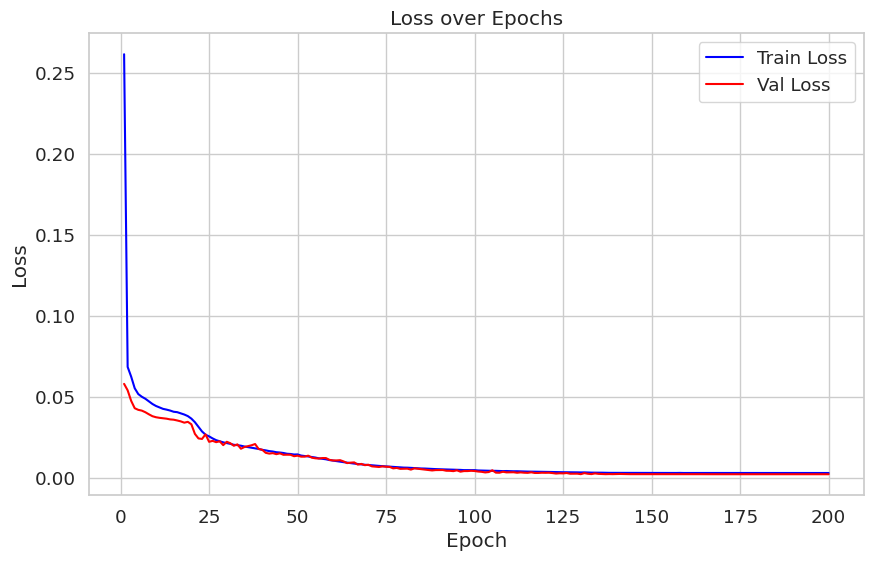

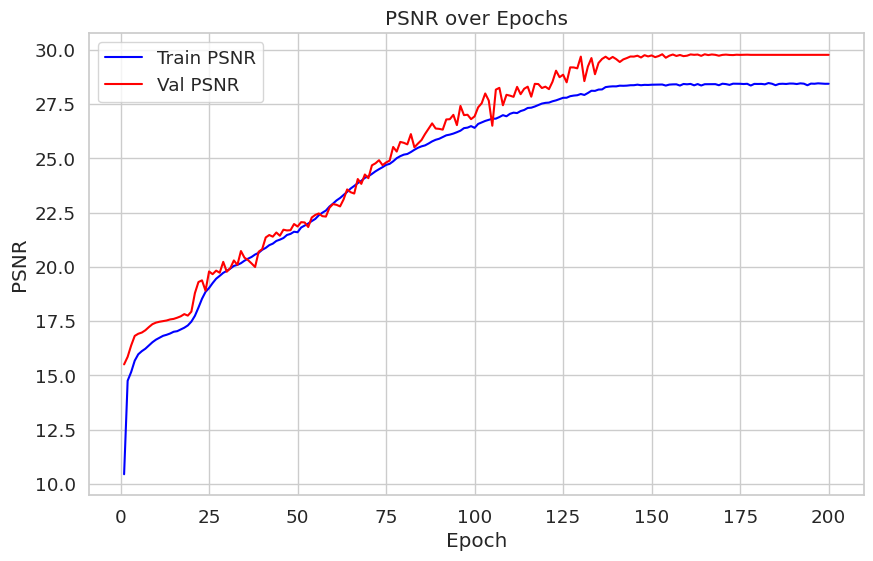

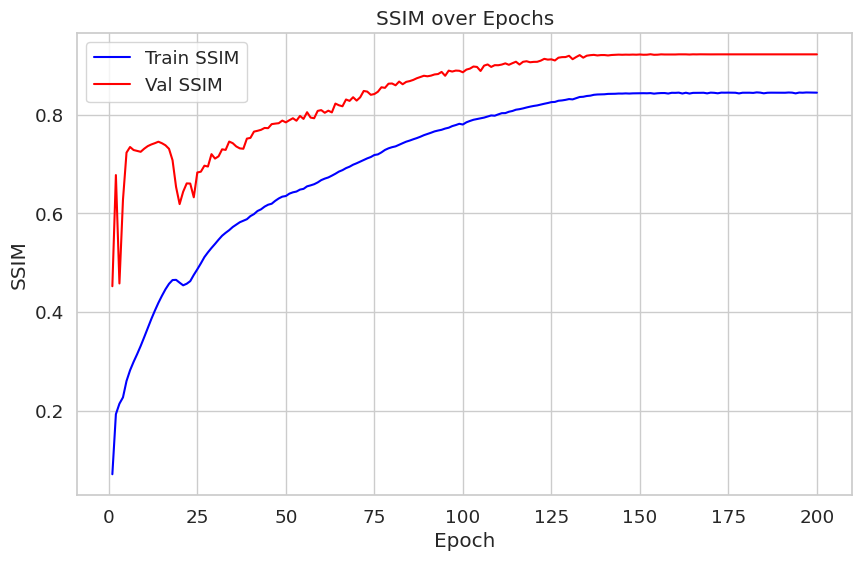

In [11]:
sns.set(style="whitegrid", font_scale=1.2)
epochs = range(1, num_epochs + 1)
save_dir = "/kaggle/working/"

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'MAE_Losses.png'))
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_psnrs, label='Train PSNR', color='blue')
plt.plot(epochs, val_psnrs, label='Val PSNR', color='red')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'PSNR.png'))
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_ssims, label='Train SSIM', color='blue')
plt.plot(epochs, val_ssims, label='Val SSIM', color='red')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'SSIM.png'))
plt.show()

## Evaluation

In [12]:
# state_dict = torch.load("/kaggle/working/best_fine_tuned_vit_model_clas.pth", map_location=device, weights_only=True)
# model.load_state_dict(state_dict)

# all_probs_test = []
# all_labels_test = []
# val_correct, val_total = 0, 0

# with torch.no_grad():
#     for batch_data, batch_labels in val_loader:
#         batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
#         batch_data = image_to_patches(batch_data, patch_size)

#         outputs = model(batch_data)

#         _, predicted = torch.max(outputs, 1)
#         val_correct += (predicted == batch_labels).sum().item()
#         val_total += batch_labels.size(0)

#         probs = torch.softmax(outputs, dim=1)
#         all_probs_test.extend(probs.cpu().detach().numpy())
#         all_labels_test.extend(batch_labels.cpu().numpy())

# val_acc = val_correct / val_total
# print(f"Accuracy: {(val_acc*100):.2f}%")

# # Step 1: Binarize the labels
# all_labels_test = np.array(all_labels_test)
# all_probs_test = np.array(all_probs_test)

# n_classes = len(np.unique(all_labels_test))
# all_labels_test_bin = label_binarize(all_labels_test, classes=np.arange(n_classes))

# # Step 2: Compute ROC curve and AUC for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(all_labels_test_bin[:, i], all_probs_test[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Step 3: Compute micro-average ROC curve and AUC
# fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_test_bin.ravel(), all_probs_test.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# # Step 4: Plot ROC curves
# label_map = {0:"no", 1:"sphere", 2: "vort"}
# plt.figure(figsize=(8, 6))
# colors = cycle(["aqua", "darkorange", "cornflowerblue"])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f"ROC curve of class {label_map[i]} (AUC = {roc_auc[i]:.2f})")

# plt.plot(fpr["micro"], tpr["micro"], color="deeppink", linestyle=":", linewidth=4,
#          label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})")

# plt.plot([0, 1], [0, 1], "k--", lw=2)
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Multiclass ROC Curve")
# plt.legend(loc="lower right")
# plt.savefig(os.path.join(save_dir, 'ROC_curve.png'))
# plt.show()

# # Step 5: Compute AUC using roc_auc_score with multi_class='ovr'
# val_auc = roc_auc_score(all_labels_test, all_probs_test, multi_class='ovr')
# print(f"AUC (One-vs-Rest, macro-average): {val_auc:.2f}")

# # Optional: Compute AUC with different averaging methods
# val_auc_micro = roc_auc_score(all_labels_test, all_probs_test, multi_class='ovr', average='micro')
# val_auc_weighted = roc_auc_score(all_labels_test, all_probs_test, multi_class='ovr', average='weighted')
# print(f"AUC (One-vs-Rest, micro-average): {val_auc_micro:.2f}")
# print(f"AUC (One-vs-Rest, weighted-average): {val_auc_weighted:.2f}")